In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [2]:
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape
import asf_search as asf
from datetime import datetime, date, timedelta
from typing import List
from pystac_client import Client, ItemSearch
import geopandas as gpd
from rasterio.crs import CRS
import contextily as cx
import pandas as pd
from shapely.ops import unary_union
from itertools import combinations
import formatting as f
import search as s

In [77]:
from importlib import reload
reload(f)

<module 'formatting' from '/Users/angelac/ground-swath/Angela_notebooks/formatting.py'>

In [74]:
# calculate cadence
def get_cadence(results):
    
    cadence = ''
    if len(results) == 0:
        cadence = 'There is no coverage during this time'

    else:
        if len(results) == 1:
            try:
                cadence = 'Only one acquisition on ' + results.startTime[0]
            except:
                cadence = 'Only one acquisition on ' + results.start_datetime[0]

        else:
            cadence = []
            for i in range(len(results) - 1):
#                 try:
#                     cadence.append(str(f.asfsearch2datetime(results.startTime[i]) - f.asfsearch2datetime(results.startTime[i + 1])))
#                 except:
#                     cadence.append(str(f.asfsearch2datetime(results.start_datetime[i + 1]) - f.asfsearch2datetime(results.start_datetime[i])))
                cadence.append(str(f.asfsearch2datetime(str(results.startTime[i])) - f.asfsearch2datetime(str(results.startTime[i + 1]))))
        
    return cadence

In [67]:
def get_coverage(sensor: List[str], aoi: Point, date: List[datetime] = None) -> List[dict]:
    """
    Sensor: choose sentinel1, sentinel2, landsat8
    AOI: enter coordinates as Polygon object
    date: leave as none if searching today, else enter time range as datetime tuple: datetime(YYYY,MM,DD)
    """
    freq = {}
    next_acq = {}
    area = {}
    
    for sensor_name in sensor:
        freq[sensor_name] = ''
        next_acq[sensor_name] = ''
        area[sensor_name] = ''
        
        if 'landsat8' in sensor_name.lower():
            results = s.hls_search('landsat8', aoi, date)
            df = f.format_results_for_hls(results)
#             print('here')
        elif 'sentinel1' in sensor_name.lower():
            results = s.asf_search(aoi, date)
            df = f.format_results_for_sent1(results)
        elif 'sentinel2' in sensor_name.lower():
            results = s.hls_search('sentinel2', aoi, date)
            df = f.format_results_for_hls(results)
        
        try:
            df = df.dissolve(by='datetime').reset_index()
        except:
            df = df.dissolve(by='startTime').reset_index()
        
        # return cadence as string or list using get_cadence
        freq[sensor_name] = get_cadence(df)
        
        # find next acquisition time, if search time is today then returns 'N/A'
        if date == None:
            next_acq[sensor_name] = 'N/A'
            
        else:
            next_acq[sensor_name] = s.acq_search(sensor_name.lower(), aoi, date[1])
        
        # find area intersection for each sensor
#         coords = [Polygon(c) for c in coords]
#         area[sensor_name] = unary_union([a.intersection(b) for a, b in combinations(coords, 2)])
        
        if len(results) == 0:
            area[sensor_name] = 0
        else:
            area[sensor_name] = df.geometry[0]
            
            if len(results) > 1:
                
                for i in range(len(df) - 1):
                    area[sensor_name] = area[sensor_name].intersection(df.geometry[i + 1])
         
    return freq, next_acq, area

### Polygons of areas of interest:

Ridgecrest coordinates: Polygon([[-117.7167, 35.5909],[-117.6322, 35.5909],[-117.6322, 35.6452],[-117.7167, 35.6452],[-117.7167, 35.5909]])

Wax lake delta: Polygon([[-91.4964, 29.4641],[-91.3849, 29.4641],[-91.3849, 29.5627],[-91.4964, 29.5627],[-91.4964, 29.4641]])

Laurentides forest in Canada: Polygon([[-75.0327, 46.0832],[-74.8823, 46.0832],[-74.8823, 46.1914],[-75.0327, 46.1914],[-75.0327, 46.0832]])

In [5]:
# create shapely and geodataframe files of areas of interest
ridgecrest = Polygon([[-117.7167, 35.5909],[-117.6322, 35.5909],[-117.6322, 35.6452],[-117.7167, 35.6452],[-117.7167, 35.5909]])
waxlake = Polygon([[-91.4964, 29.4641],[-91.3849, 29.4641],[-91.3849, 29.5627],[-91.4964, 29.5627],[-91.4964, 29.4641]])
laurentides = Polygon([[-75.0327, 46.0832],[-74.8823, 46.0832],[-74.8823, 46.1914],[-75.0327, 46.1914],[-75.0327, 46.0832]])
ridgecrest_df = f.shape2gdf(ridgecrest, 'ridgecrest')
waxlake_df = f.shape2gdf(waxlake, 'waxlake')
laurentides_df = f.shape2gdf(laurentides, 'laurentides')

In [79]:
reload(f)

<module 'formatting' from '/Users/angelac/ground-swath/Angela_notebooks/formatting.py'>

In [80]:
freq, next_acq, area = get_coverage(['sentinel1'], laurentides, [datetime(2022,1,1), datetime(2022,2,1)])

KeyError: -1

In [61]:
freq3, next_acq3, area3 = get_coverage(['sentinel2','landsat8'],laurentides,[datetime(2022,1,1), datetime(2022,2,1)])


22
2
8
0


/Users/angelac/ground-swath/Angela_notebooks/formatting.py:52: UserWarning: Dataframe is empty! Check inputs.
  


2


In [35]:
freq3['landsat8']

['7 days, 0:06:09.592000', '8 days, 23:53:45.752000', '7 days, 0:06:09.381000']

### Work in progress

In [38]:
# print(freq3['landsat8'])
# print(next_acq3['landsat8'])
# print(freq3['sentinel1'])
# print(next_acq3['sentinel1'])
print(freq3['sentinel2'])
print(next_acq3['sentinel2'])

['0:00:04.401000', '4 days, 23:59:49.942000', '0:00:04.398000', '1 day, 23:50:04.587000', '0:00:03.261000', '3 days, 0:09:52.701000', '0:00:04.405000', '1 day, 23:49:54.053000', '0:00:03.264000', '3 days, 0:09:52.691000', '0:00:04.402000', '1 day, 23:50:03.846000', '0:00:03.266000', '3 days, 0:09:53.157000', '0:00:04.402000', '1 day, 23:49:53.480000', '0:00:03.269000', '3 days, 0:09:52.650000', '0:00:04.407000', '1 day, 23:50:05.581000', '0:00:03.264000']
2022-02-04T16:00:15.136Z


In [11]:
df = f.format_results_for_hls(d)

In [12]:
df

,datetime,start_datetime,end_datetime,eo:cloud_cover,geometry,startTime,stopTime
0,2022-01-08T15:44:18.159Z,2022-01-08T15:44:18.159Z,2022-01-08T15:44:42.038Z,27,"POLYGON ((-75.74016 45.96315, -74.87403 45.965...",2022-01-08 15:44:18.159000+00:00,2022-01-08 15:44:42.038000+00:00
1,2022-01-08T15:44:18.159Z,2022-01-08T15:44:18.159Z,2022-01-08T15:44:42.038Z,5,"POLYGON ((-73.58334 45.95677, -73.55749 46.944...",2022-01-08 15:44:18.159000+00:00,2022-01-08 15:44:42.038000+00:00
2,2022-01-15T15:50:27.751Z,2022-01-15T15:50:27.751Z,2022-01-15T15:50:51.633Z,24,"POLYGON ((-76.29100 45.95826, -74.87403 45.965...",2022-01-15 15:50:27.751000+00:00,2022-01-15 15:50:51.633000+00:00
3,2022-01-15T15:50:27.751Z,2022-01-15T15:50:27.751Z,2022-01-15T15:50:51.633Z,13,"POLYGON ((-74.79698 45.96537, -74.40336 46.952...",2022-01-15 15:50:27.751000+00:00,2022-01-15 15:50:51.633000+00:00
4,2022-01-24T15:44:13.503Z,2022-01-24T15:44:13.503Z,2022-01-24T15:44:37.390Z,98,"POLYGON ((-75.73899 45.96316, -74.87403 45.965...",2022-01-24 15:44:13.503000+00:00,2022-01-24 15:44:37.390000+00:00
5,2022-01-24T15:44:13.503Z,2022-01-24T15:44:13.503Z,2022-01-24T15:44:37.390Z,75,"POLYGON ((-73.58334 45.95677, -73.55749 46.944...",2022-01-24 15:44:13.503000+00:00,2022-01-24 15:44:37.390000+00:00
6,2022-01-31T15:50:22.884Z,2022-01-31T15:50:22.884Z,2022-01-31T15:50:46.762Z,27,"POLYGON ((-76.29100 45.95826, -74.87403 45.965...",2022-01-31 15:50:22.884000+00:00,2022-01-31 15:50:46.762000+00:00
7,2022-01-31T15:50:22.884Z,2022-01-31T15:50:22.884Z,2022-01-31T15:50:46.762Z,13,"POLYGON ((-74.79659 45.96537, -74.40297 46.952...",2022-01-31 15:50:22.884000+00:00,2022-01-31 15:50:46.762000+00:00


In [13]:
df_dis = df.dissolve(by='datetime').reset_index()
df_dis.start_datetime

0    2022-01-08T15:44:18.159Z
1    2022-01-15T15:50:27.751Z
2    2022-01-24T15:44:13.503Z
3    2022-01-31T15:50:22.884Z
Name: start_datetime, dtype: object

In [71]:
f.asfsearch2datetime(df_dis.start_datetime[0])

datetime.datetime(2022, 1, 8, 15, 44, 18, 159000)

In [15]:
cadence = get_cadence(df_dis)

In [16]:
cadence

['7 days, 0:06:09.592000', '8 days, 23:53:45.752000', '7 days, 0:06:09.381000']

In [ ]:
world = gpd.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


In [ ]:
world.plot(figsize=(10,10))

In [ ]:
world.head()

In [ ]:
df_cont = world.dissolve(by='continent').reset_index()
df_cont.iloc[:1].plot()

In [ ]:
world.dissolve(by='continent').plot(figsize=(10,10))
# world.plot()

In [ ]:
df_1.head()

### The below cells are just for reminding what format the output results have

In [63]:
wkt = laurentides.wkt
opts = {
    'platform': asf.PLATFORM.SENTINEL1,
    'processingLevel': [asf.PRODUCT_TYPE.SLC],
    'beamMode': [asf.BEAMMODE.IW],
    'start': '2022-01-01T00:00:00Z',
    'end': '2022-02-01T23:59:59Z'
}
results = asf.search(intersectsWith=wkt,**opts)
print(len(results))

2


In [65]:
sent1_forest = f.format_results_for_sent1(results)

In [76]:
type(sent1_forest.startTime[0])

pandas._libs.tslibs.timestamps.Timestamp

In [43]:
STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'
api = Client.open(f'{STAC_URL}/LPCLOUD/')
hls_collections = ['HLSL30.v2.0']
search_params = {"collections": hls_collections,
                 "bbox": [-75.0327, 46.0832, -74.8823, 46.1914], # list of xmin, ymin, xmax, ymax
                 "datetime": [datetime(2022,1,1), datetime(2022,2,1)],
                 }
search_hls = api.search(**search_params)
hls_collection = search_hls.get_all_items()
e = list(hls_collection)
# d[0].properties

In [42]:
d[1].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'HLS.S30.T18TVS.2022003T160651.v2.0',
 'properties': {'datetime': '2022-01-03T16:10:23.095000Z',
  'start_datetime': '2022-01-03T16:10:23.095Z',
  'end_datetime': '2022-01-03T16:10:23.095Z',
  'eo:cloud_cover': 0},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-76.2894519, 45.9582762],
    [-74.8740327, 45.9654817],
    [-74.871733, 46.9536373],
    [-76.3145607, 46.9461622],
    [-76.2894519, 45.9582762]]]},
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0/items/HLS.S30.T18TVS.2022003T160651.v2.0'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v2.0'},
  {'rel': <RelType.ROOT: 'root'>,
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/',
   'type': <MediaType.JSON: 'application/json'>,
   'title': 'LPCLOUD'},


In [ ]:
df.iloc[:2].to_file('test2.geojson',driver='GeoJSON')

In [ ]:
for i in range(len(d)):
    print(d[i].properties['datetime'])

In [ ]:
shape(area1['sentinel1'])

# Visualization

In [58]:
# returns filled-in plot or outline of dictionary of polygons (or single polygon) with world map underneath
def visual(area, outline = False):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    
    if type(area) == dict:
        
        color = ['blue','green','red']
    
        for num,frame in enumerate(area.keys()):
            df = gpd.GeoDataFrame(geometry = [area[frame]],
                                  crs = CRS.from_epsg(4326))
            df_wm = df.to_crs(epsg = 3857)
            if not outline:
                df_wm.plot(ax = ax, alpha = .3, color=color[num], legend = True)
            else:
                df_wm.boundary.plot(ax = ax, color=color[num])
            
    elif type(area) == gpd.GeoSeries:
        
        df_wm = area.to_crs(epsg = 3857)
        if not outline:
            df_wm.plot(ax = ax, alpha = .3)
        else:
            df_wm.boundary.plot(ax = ax)
        
    elif type(area) == Polygon:
        
        df = gpd.GeoDataFrame(geometry = [area],
                                  crs = CRS.from_epsg(4326))
        df_wm = df.to_crs(epsg = 3857)
        if not outline:
            df_wm.plot(ax = ax, alpha = .3)
        else:
            df_wm.boundary.plot(ax = ax)
    
    cx.add_basemap(ax, zoom = 10)

In [ ]:
# returns plot of intersection of all polygons in input dictionary
def find_overlap(area: dict, outline = False):
    
    for idx,key in enumerate(area.keys()):
        if idx == 0:
            overlap = area[key]
        else:
            overlap = overlap.intersection(area[key])
            
    visual(overlap, outline)

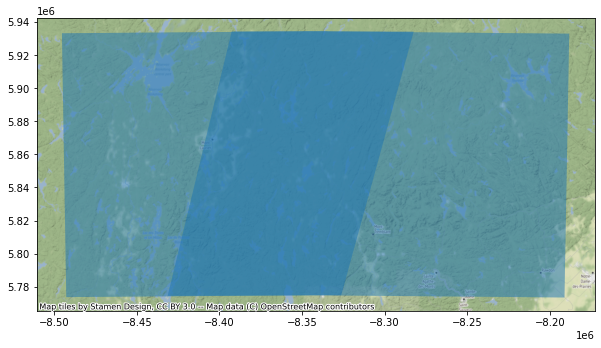

In [59]:
visual(df_dis.geometry)

In [ ]:
find_overlap(area1)

In [ ]:
visual(area1['sentinel1'],outline=True)

In [ ]:
visual(area1['sentinel1'])

In [ ]:
visual(area1)

In [ ]:
visual(area2)

In [ ]:
visual(area3)

### Deprecated